# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2008,2019)    #(1997,2021) # Set years to download

In [2]:
import os
datapath   = os.path.join('../')
print('datapath is set to %s'%datapath)

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly 
# !pip install cufflinks
#!pip install colorspacious
#!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
from Loobos_Toolbox import dateparse, dateparse_Gapfilled, Read_LoobosEddFinal, Read_LooStor, Read_LoodatGapfill, Read_Loobos_halfhourly, Read_Loobos_meteo, Read_Loobos_soil, Read_Loobos_profile

from Ags_model import runAgs, calc_LE

datapath is set to ../


In [3]:
#these next two lines are to prevent re-loading the data. If you want to re-load data, instead comment them out
if not 'progress' in globals(): progress = list()
if not 'dataloaded' in progress:
  # Read files
    df_EC           = Read_LoobosEddFinal    (years,datapath)
    df_Stor         = Read_LooStor           (years,datapath)
    df_Comb         = Read_LoodatGapfill     (years,datapath)
    df_NEE          = Read_Loobos_halfhourly (years,datapath)
    df_meteo        = Read_Loobos_meteo      (years,datapath)
    df_soil         = Read_Loobos_soil       (years,datapath) 
    df_profile      = Read_Loobos_profile    (years,datapath)
    progress.append('dataloaded')

Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
df_EC loaded. Columns in this dataframe:
Index(['Doy', 'Dtime', 'Flx_Tsonic', 'Flx_Lo-H2O', 'Flx_Lo-CO2', 'Qf_Tsonic',
       'Qf_Lo-H2O', 'Qf_Lo-CO2', 'Mea_Windsp', 'Mea_Tsonic', 'Mea_Lo-H2O',
       'Mea_Lo-CO2', 'U-star', 'Z-over-L', 'Wind-Dir', '80PercFlux'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2018
df_Stor loaded. Columns in this dataframe:
Index(['Day', 'Time', 'TotalT', 'TotalTflux', 'TotalH2O', 'TotalH2Oflux',
       'TotalCO2', 'TotalCO2flux', 'CO2-2.5m', 'CO2flux-2.5m'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
df_Comb loaded. Columns in this dataframe:
Index(['Year', 'DoY', 'Hour', 'qcNEE', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil',
       'rH', 'Ustar', 'VPD', 'NEE_orig', 'NEE_f', 'NEE_fqc', 'NEE_fall',
       'NEE_fall_qc', 'NEE_fnum', 'NEE_fsd', 'NEE_fmeth', 'NEE_fwin',
       'Rg_orig', 'Rg_f', 'Rg_fqc', 'Rg_fall', 'Rg_fall_qc', 'Rg_fnum',
       'Rg_fsd', 'Rg_fmeth', 'Rg_fwin', 'H_orig', 'H_f', 'H_fqc', 'H_fall',
       'H_fall_qc', 'H_fnum', 'H_fsd', 'H_fmeth', 'H_fwin', 'LE_orig', 'LE_f',
       'LE_fqc', 'LE_fall', 'LE_fall_qc', 'LE_fnum', 'LE_fsd', 'LE_fmeth',
       'LE_fwin', 'Tair_orig', 'Tair_f', 'Tair_fqc', 'Tair_fall',
       'Tair_fall_qc', 'Tair_fnum', 'Tair_fsd', 'Tair_fmeth', 'Tair_fwin',
       'PotRad', 'FP_NEEnight', 'FP_Temp', 'E_0', 'R_ref', 'Reco', 'GPP_f',
       'GPP_fqc'],
      dtype='object')
Loading 2008
Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2012
Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2016
Loading 2017


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2018
Done
df_NEE loaded. Columns in this dataframe:
Index(['NEE_f', 'H_f', 'LE_f', 'Reco_f', 'GPP_f'], dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_meteo loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'S(i)', 'S(o)', 'L(i)', 'L(o)', 'L(i)corr',
       'L(o)corr', 'R(net)', 'PARrefl', 'PAR', 'PARdiff', 'G1', '-q',
       'Te(vaisal)', 'Te-L(i)', 'Te-L(o)', '-u(z)', '-u(dir)', 'H2Olic',
       'CO2lic', 'Vbatt', 'CR10temp', 'P(mast)', 'P(guter)', 'P(field)',
       'SD S(i)', 'SD L(i)', 'SD q', 'SD Te(vaisal)', 'SD u(z)'],
      dtype='object')
Loading ../\Soilmoist\Final\Loosoifinal08.csv...
Loading ../\Soilmoist\Final\Loosoifinal09.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal10.csv...
Loading ../\Soilmoist\Final\Loosoifinal11.csv...
Loading ../\Soilmoist\Final\Loosoifinal12.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future vers

Loading ../\Soilmoist\Final\Loosoifinal13.csv...
Loading ../\Soilmoist\Final\Loosoifinal14.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal15.csv...
Loading ../\Soilmoist\Final\Loosoifinal16.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal17.csv...
Loading ../\Soilmoist\Final\Loosoifinal18.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_soil loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'SM-Lit', 'SM-003', 'SM-020', 'SM-050', 'SM-100',
       'ST-Lit', 'ST-003', 'ST-020', 'ST-050', 'ST-100', 'T-bole', 'Temp200',
       'Temp201', 'Temp202', 'Temp203', 'Temp204', 'Temp205', 'Temp206',
       'Temp207'],
      dtype='object')
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
Loading 2018
df_profile loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'VaiVPtop', 'VaiVPmid', 'Vtemptop', 'Vtempmid',
       'VecWStop', 'VecWSmid', 'Pressure', 'H2Olevel1', 'H2Olevel2',
       'H2Olevel3', 'H2Olevel4', 'H2Olevel5', 'CO2level1', 'CO2level2',
       'CO2level3', 'CO2level4', 'CO2level5', 'H2Ocal', 'CO2cal'],
      dtype='object')


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


In [4]:
#OLD filters
# Make filter for GPP orginial data and not gabfilled
#I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))

# Filter for CO2 data
#t = df_profile.index                                          
#time = (t < np.datetime64('2013-05-08')) | (t > np.datetime64('2013-06-01'))
#CO2 = (df_profile['CO2level1'] > 300)

#General filter
#I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))

#df_meteo_CO2 = df_meteo[time][CO2]
#df_meteo_filter = df_meteo_CO2[I]

#df_Comb_CO2 = df_Comb[time][CO2]
#df_Comb_filter = df_Comb_CO2[I]

#df_profile_CO2 = df_profile[time][CO2]
#df_profile_filter = df_profile_CO2[I]

#df_EC_CO2 = df_EC[time][CO2]
#df_EC_filter = df_EC_CO2[I]

In [5]:
# Make filter for GPP orginial data and not gapfilled
#General filters
I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))
#t = df_profile.index                                          
#time = (t < np.datetime64('2013-05-08')) | (t > np.datetime64('2013-06-01'))

# Filter for CO2 data
CO2 = (df_profile['CO2level1'] > 300)

# Filter for L(o)corr data
Locorr= (df_meteo['L(o)corr']>0) 

# Filter for VPD data
VPD = (df_Comb['VPD']>=0)

# Filter for U-star
Ustar = (df_EC['U-star']>=0)

# Combine all filters
filter = I & CO2 & Locorr & VPD & Ustar

#Column 'CO2' is input from df_profile
#df_profile_CO2 = df_profile[CO2]
#df_profile_filter = df_profile_CO2[I]
df_profile_filter = df_profile[filter]

#Column 'L(o)corr' and 'PAR' are inputs from df_meteo
#df_meteo_CO2 = df_meteo[CO2]
#df_meteo_filter = df_meteo_CO2[I]
df_meteo_filter = df_meteo[filter]

#Columns 'VPD' and 'Tair' are inputs from df_Comb
#df_Comb_CO2 = df_Comb[CO2]
#df_Comb_filter = df_Comb_CO2[I]
df_Comb_filter = df_Comb[filter]

# Columns 'Mea_Windsp' and 'U-star' are inputs from df_EC
#df_EC_CO2 = df_EC[CO2]
#df_EC_filter = df_EC_CO2[I]
df_EC_filter = df_EC[filter]

### Run A-gs model

In [6]:
# Run A-gs model
#fstr=1.0
#an_final,an_umol,rs, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr)

# Run A-gs model for different fstr values

an_final_10,an_umol_10,rs_10, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=1.0)
an_final_8,an_umol_8,rs_8, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.8)
an_final_6,an_umol_6,rs_6, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.6)
an_final_4,an_umol_4,rs_4, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.4)
an_final_2,an_umol_2,rs_2, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=0.2)


### Assemble dataframe 'df_ET' for simulated LE

In [7]:
df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
#convert Pressure from hPa to kPa 
df_ET['p_kPa']=df_ET['Pressure']/10
df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa

In [8]:
def init_ETframe(rs_series):
    df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
    #convert Pressure from hPa to kPa 
    df_ET['p_kPa']=df_ET['Pressure']/10
    df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
    df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa
    df_ET['rs']=rs_series.to_frame(name="rs")
    df_ET['ra']=ra.to_frame(name="ra")
    return df_ET

In [9]:
df_ET_10=init_ETframe(rs_10)
df_ET_8=init_ETframe(rs_8)
df_ET_6=init_ETframe(rs_6)
df_ET_4=init_ETframe(rs_4)
df_ET_2=init_ETframe(rs_2)

### calculate ET

In [7]:
df_ET=calc_LE(df_ET,rs,ra)

In [10]:
df_ET_10=calc_LE(df_ET_10)
df_ET_8=calc_LE(df_ET_8)
df_ET_6=calc_LE(df_ET_6)
df_ET_4=calc_LE(df_ET_4)
df_ET_2=calc_LE(df_ET_2)

### Calculate gs from Penman-Monteith

In [11]:
start='2017-04-14 00:00'
end='2017-04-30 00:00'

rs=rs_8

df_ra=pd.DataFrame({'ra':ra})
df_rs=pd.DataFrame({'rs':rs})
#calculate inverse of aerodynamic resistance, aero conductance
df_ra['ga'] = 1. / df_ra['ra']
#and stomatal conductance
df_rs['gs'] = 1. / df_rs['rs']
df_ra=df_ra.resample("1H").mean()
df_rs=df_rs.resample("1H").mean()

df_gs=pd.concat([df_profile_filter['Pressure'],df_Comb_filter['LE'],df_Comb_filter['rH'],df_Comb_filter['Tair'],df_Comb_filter['VPD'],df_meteo_filter['P(mast)'],df_meteo_filter['R(net)'],df_meteo_filter['G1']],axis=1,sort=False)
df_gs['Tair_K']=df_gs['Tair']+273.15
df_gs['p_kPa']=df_gs['Pressure']/10
df_gs['p_kPa']=df_gs['p_kPa'].loc[df_gs['p_kPa']>1]
df_gs['LE']=df_gs['LE'].loc[df_gs['LE']>-5]
df_gs['VPD_adj']=df_gs['VPD'].loc[df_gs['VPD']>0] #some outlier values for VPD are negative, remove from dataset
df_gs['VPD_adj']=df_gs['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa

df_gs['last3day_prec']=df_gs['P(mast)'].rolling('72H').sum()
df_gs=df_gs.loc[df_gs['last3day_prec']==0]


#df_gs=df_gs.resample("M").mean()

#df_gs=df_gs.loc[df_gs['rH']<95.0]
#df_gs['Tair'].plot()
#df_rs['gs'].plot()

In [12]:
#calculating q and cp

    #constants:
e_sat_0 = 0.6107 # e_sat_0 = 0.6107 kPa or 610.7 Pa
a = 7.5
b = 237.3 # oC (geen typo)
df_gs['e_sat'] = e_sat_0 * 10**(a*df_gs['Tair'] / (b+df_gs['Tair'])) #  T_sfc_C in oC
Rd = 287 # J/kg K
Rv = 462 # J/kg K
df_gs['q_sat'] = Rd/Rv * df_gs['e_sat']/df_gs['p_kPa'] #q = Rd/Rv * e/p -> q_sat = Rd/Rv * e_sat/p
df_gs['e_act'] = df_gs['e_sat'] - df_gs['VPD_adj'] #VPD = e_sat - e_act -> e_act = e_sat - VPD
df_gs['q_act'] = Rd/Rv * df_gs['e_act']/df_gs['p_kPa'] #q = Rd/Rv * e/p . output is in g/kg (order of magnitude 0.005-0.015)
#now from q calculate cp
cpd=1004.67 #J/kg/K
df_gs['cp_calc']=cpd*(1+0.84*df_gs['q_act']) #q in g/kg?


#df_gs['cp_calc'].plot()


In [13]:
#gs sim vs gs calculated plot
#like in research paper by eline floor houwen

#df_gs=df_gs.resample('3H').mean()
#df_gs=df_gs.between_time('9:00','15:00')

rho=1.2  
#cpd=1004.67 #J/kg/K
#cp=cpd*(1+0.84q) #q in g/kg?
cp=1006  #J/kg/K , approximation
Lv=2.26 #MJ/kg, based on 2260000 J/kg 
cp_calc=df_gs['cp_calc']

df_gs['gamma'] = (cp * df_gs['p_kPa']*1000) / (0.622 * Lv*1000000) #cp in J/kg/K , P in Pa, Lv in J/kg
df_gs['gamma_1'] = (cp_calc * df_gs['p_kPa']*1000) / (0.622 * Lv*1000000) #cp in J/kg/K , P in Pa, Lv in J/kg

#example value for psychometric constant is 0.054 kPa/°C or 50Pa/°C 

df_gs['delta'] = 4098 * (0.6108 * np.exp((17.27*df_gs['Tair'])/(df_gs['Tair']+237.3))) / ((df_gs['Tair']+237.3)**2)  # T in C,

#df_gs['gamma'].plot()
#df_gs['gamma_1'].plot()

<Axes: title={'center': 'simulated and observed gs'}, ylabel='m/s'>

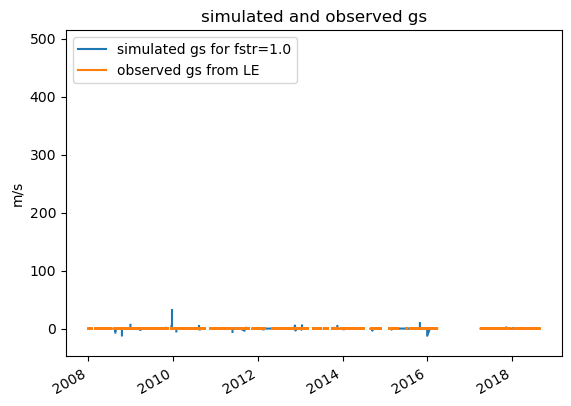

In [14]:
LE=df_gs['LE'] # in the order of 50Wm-2, ranges 16-94
gamma=df_gs['gamma_1'] #in the order of 72 Pa/K or 0.072, ranges 71.51-72.8 #BUT THE EQUATION EXPECTS kPa/K!
ga=df_ra['ga'] # in the order of 0.14, ranges 0.104-0.266
delta=df_gs['delta'] #in the order of 0.10 ranges 0.04-0.15
Rnet=df_gs['R(net)'] #in the order of 100, ranges 3-222
G=df_gs['G1'] #in the order of 0.1, ranges -3 to +3 # SUSPECT value, however R(net)-G1 ranges from 6.28-219.69 so never becomes negative
#cp=df_gs['cp']
VPD=df_gs['VPD_adj'] #in order of  0.60, ranges 0.059-1.33

first_term = df_gs['LE']*(df_gs['gamma_1']/1000)*df_ra['ga']
second_term=delta*(Rnet-G)
third_term=rho*cp_calc*ga*VPD
fourth_term=LE*(delta+(df_gs['gamma_1']/1000))

df_gs['gs'] = (first_term) / ( (second_term) + (third_term) - (fourth_term) )
df_gs['lower_half']= (second_term) + (third_term) - (fourth_term)

#df_gs['gs'].plot()
#df_gs['gs'] = (LE*gamma*ga) / ( (delta*(Rnet-G)) + (rho*cp*ga*VPD) - (LE*(delta+gamma)) )

#df_gs['gs'] = (df_gs['LE'] * df_gs['gamma'] * df_ra['ga']) /(df_gs['delta']*(df_gs['R(net)']-df_gs['G1']) + rho*df_gs['cp']*df_ra['ga']*df_gs['VPD_adj'] - df_gs['LE']*(df_gs['delta']+df_gs['gamma']))

df_gs['gs'].plot(label="simulated gs for fstr=1.0",legend="yes",title="simulated and observed gs",ylabel="m/s")
df_rs['gs'].plot(label="observed gs from LE",legend="yes")
#df_gs['P(mast)'].plot()
#first_term.plot()
#second_term.plot()
#third_term.plot()
#fourth_term.plot()
#((second_term) + (third_term)).plot()
#plotting

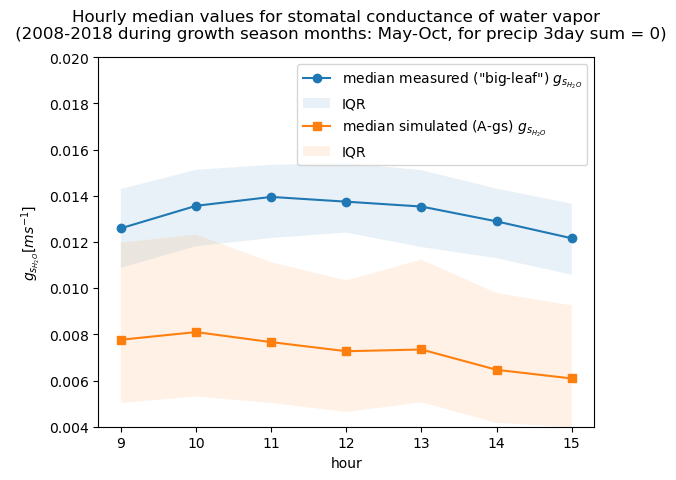

In [33]:
#draw binned gs
start='2008-04-01 00:00'
end='2018-08-30 00:00'

sim_data=df_gs.loc[start:end,['gs','P(mast)']].resample('1H').mean()#.between_time("11:00", "18:00")
sim_data['last3day_prec']=sim_data['P(mast)'].rolling('72H').sum()
sim_data=sim_data.loc[sim_data['last3day_prec']==0.0]

sim_data = sim_data.loc[(sim_data.index.month>=5) & (sim_data.index.month<=8)]

sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_rs['gs'].loc[start:end].resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.dropna()

#sim_data.rename("gs_sim")
#measured_data.rename("gs_meas")

df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

hours_list=[ 9, 10, 11, 12, 13, 14, 15]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_y'].median() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_y'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_y'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_x'].median() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_x'].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_x'].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

fig,ax = plt.subplots()
p1=ax.plot(hours_list,df_avg['meas_avg'],marker='o',label=r'median measured ("big-leaf") $g_{s_{H_{2}O}}$')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(hours_list,df_avg['sim_avg'],marker='s',label=r'median simulated (A-gs) $g_{s_{H_{2}O}}$')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

ax.set_ylim(0.004,0.02)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'$g_{s_{H_{2}O}} [m s^{-1}]$')
fig.suptitle('Hourly median values for stomatal conductance of water vapor \n (2008-2018 during growth season months: May-Oct, for precip 3day sum = 0)')
ax.legend(loc='upper right')


,meas_avg,meas_q1,meas_q3,sim_avg,sim_q1,sim_q3
0,0.012402,0.010877,0.014288,0.002444,0.005030,0.011967
1,0.013340,0.011815,0.015122,0.016541,0.005307,0.012315
2,0.013616,0.012168,0.015333,0.014027,0.005030,0.011126
3,0.013655,0.012406,0.015416,0.008426,0.004637,0.010332
4,0.013301,0.011778,0.015106,0.010847,0.005057,0.011235
5,0.012622,0.011297,0.014306,0.009013,0.004165,0.009787
6,0.011874,0.010579,0.013653,0.009703,0.003976,0.009252


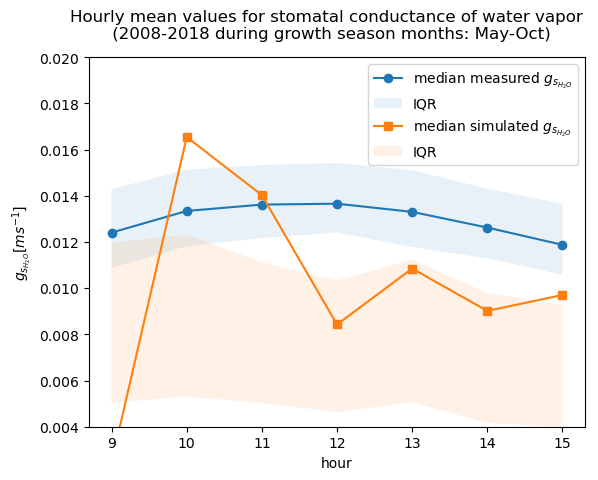

In [19]:
#draw binned gs
start='2008-04-01 00:00'
end='2018-08-30 00:00'

sim_data=df_gs.loc[start:end,['gs','P(mast)']].resample('1H').mean()#.between_time("11:00", "18:00")
sim_data['last3day_prec']=sim_data['P(mast)'].rolling('72H').sum()
sim_data=sim_data.loc[sim_data['last3day_prec']==0.0]

sim_data = sim_data.loc[(sim_data.index.month>=5) & (sim_data.index.month<=8)]

sim_data=sim_data.dropna() #eliminate NaN entries created by the .loc slice
measured_data=df_rs['gs'].loc[start:end].resample('1H').mean()#.between_time("11:00", "18:00")
measured_data=measured_data.dropna()

#sim_data.rename("gs_sim")
#measured_data.rename("gs_meas")

df_tmp=pd.DataFrame(sim_data)
df_tmp=df_tmp.merge(measured_data, how='inner',left_index=True, right_index=True)

hours_list=[ 9, 10, 11, 12, 13, 14, 15]

d={}
d['meas_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_y'].mean() for i in hours_list]
d['meas_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_y'].quantile(q=0.25) for i in hours_list]
d['meas_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_y'].quantile(q=0.75) for i in hours_list]
d['sim_avg'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_x'].mean() for i in hours_list]
d['sim_q1'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_x'].quantile(q=0.25) for i in hours_list]
d['sim_q3'] = [df_tmp.loc[df_tmp.index.hour==i,'gs_x'].quantile(q=0.75) for i in hours_list]

df_avg=pd.DataFrame(d)

fig,ax = plt.subplots()
p1=ax.plot(hours_list,df_avg['meas_avg'],marker='o',label=r'median measured $g_{s_{H_{2}O}}$')
ax.fill_between(hours_list,df_avg['meas_q1'],df_avg['meas_q3'],alpha=0.1,label='IQR')
p2=ax.plot(hours_list,df_avg['sim_avg'],marker='s',label=r'median simulated $g_{s_{H_{2}O}}$')
ax.fill_between(hours_list,df_avg['sim_q1'],df_avg['sim_q3'],alpha=0.1,label='IQR')

ax.set_ylim(0.004,0.02)
#ax.set_xlim(-5,40)
plt.xticks(hours_list) 
ax.set_xlabel('hour')
ax.set_ylabel(r'$g_{s_{H_{2}O}} [m s^{-1}]$')
fig.suptitle('Hourly mean values for stomatal conductance of water vapor \n (2008-2018 during growth season months: May-Oct)')
ax.legend(loc='upper right')
df_avg


<Axes: ylabel='Frequency'>

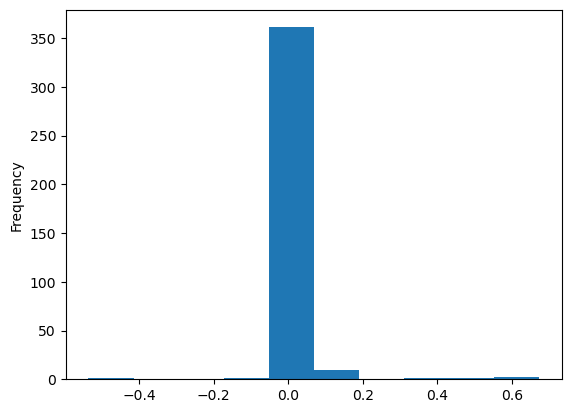

In [30]:
df_tmp.loc[df_tmp.index.hour==10,'gs_x'].plot(kind="hist")


In [60]:
df_gs['first_term'] = df_gs['LE']*(df_gs['gamma_1']/1000)*df_ra['ga']
df_gs['second_term'] = delta*(Rnet-G)
df_gs['third_term'] = rho*cp_calc*ga*VPD
df_gs['fourth_term'] = LE*(delta+(df_gs['gamma_1']/1000))

In [23]:
start='2017-11-30'
end='2018-02-28'
df_gs.loc[start:end]

,Pressure,LE,Tair,VPD,P(mast),R(net),G1,Tair_K,p_kPa,VPD_adj,...,q_act,cp_calc,gamma,gamma_1,delta,gs,first_term,second_term,third_term,fourth_term
2017-11-30,1008.932639,31.149053,6.351444,0.256240,0.046528,17.661986,-2.597124,279.501444,100.893264,0.117511,...,0.005175,1009.036954,72.204012,72.421984,0.066138,0.019825,0.235599,1.339888,14.860265,4.315998
2017-12-31,1006.704973,38.503902,4.124224,0.097343,0.070161,7.570520,-2.491897,277.274224,100.670497,0.059363,...,0.004695,1008.632452,72.044589,72.233112,0.057681,0.071058,0.375970,0.580414,9.712806,5.002214
2018-01-31,1005.845430,32.403012,4.997445,5.685213,0.063441,7.892245,-1.574438,278.147445,100.584543,0.568911,...,0.001872,1006.249731,71.983076,72.000946,0.060879,0.003527,0.340680,0.576323,100.312498,4.305713
2018-02-28,1013.252976,16.099376,-0.063888,4.089912,0.013988,43.967115,-3.560811,273.086112,101.325298,0.408991,...,0.001219,1005.698977,72.513196,72.491498,0.044268,0.002355,0.131887,2.103965,55.778703,1.879755


In [41]:
#df_gs['lower_half'].plot()
df_gs.columns
#df_ra.loc[start:end,'ga']

Index(['Pressure', 'LE', 'rH', 'Tair', 'VPD', 'P(mast)', 'R(net)', 'G1',
       'Tair_K', 'p_kPa', 'VPD_adj', 'last3day_prec', 'e_sat', 'q_sat',
       'e_act', 'q_act', 'cp_calc', 'gamma', 'gamma_1', 'delta', 'gs',
       'lower_half'],
      dtype='object')

<Axes: >

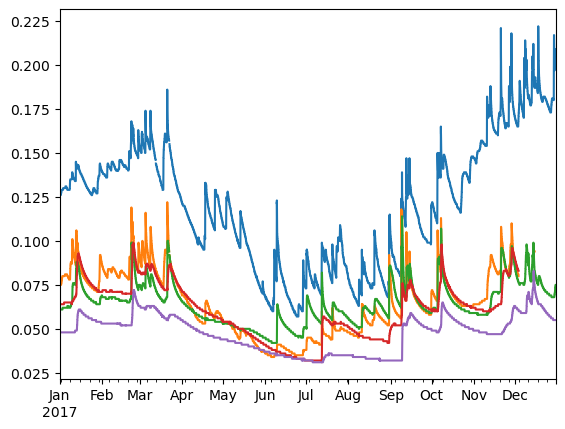

In [32]:
df_soil['SM-Lit'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-003'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-020'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-050'].loc['2017-01-01':'2017-12-30'].plot()
df_soil['SM-100'].loc['2017-01-01':'2017-12-30'].plot()

<Axes: >

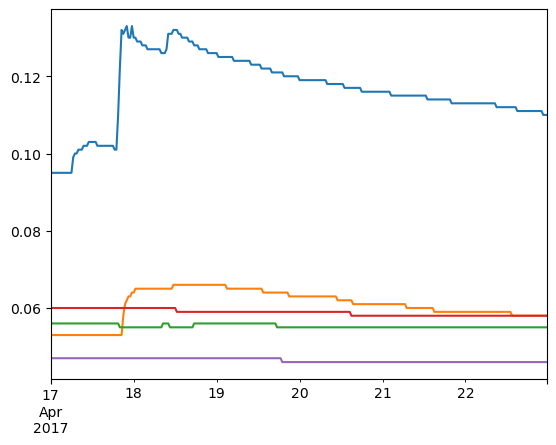

In [199]:
df_soil['SM-Lit'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-003'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-020'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-050'].loc['2017-04-17':'2017-04-22'].plot()
df_soil['SM-100'].loc['2017-04-17':'2017-04-22'].plot()